# **Modelling Sale Price using Regression**

## Objectives

*   Fit and evaluate a regression model to predict sale price based on house attributes.

## Inputs

* outputs/datasets/collection/house_prices_records.csv
* Instructions on which variables to use for data cleaning and feature engineering, found in the respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Feature importance plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


# MP Pipeline: Regressor

## Create ML pipeline

Custom code for ML pipeline taken and modified from CI's Churnometer project.

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

        ("CategoricalImputation", CategoricalImputer(imputation_method='missing',fill_value='Unf', 
                                                        variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', 
                                                variables=['LotFrontage', '2ndFlrSF', 'MasVnrArea'])),

        ("MeanImputation", MeanMedianImputer(imputation_method='mean', variables='BedroomAbvGr')),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['LotArea', 'LotFrontage'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['BsmtUnfSF', 'OpenPorchSF'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables='TotalBsmtSF')),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, 
                                                                selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for hyperparameter optimisation taken and modified from CI Churnometer project

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove

Check results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.701655,0.796835,0.844757,0.05592
3,ExtraTreesRegressor,0.653634,0.791003,0.855919,0.078968
5,GradientBoostingRegressor,0.608,0.776908,0.841736,0.087146
0,LinearRegression,0.614833,0.734306,0.807311,0.065668
6,XGBRegressor,0.595666,0.72737,0.797918,0.069458
4,AdaBoostRegressor,0.5945,0.714718,0.781695,0.066286
1,DecisionTreeRegressor,0.312063,0.55206,0.651268,0.12293


* Initial assessment of the best regression model identifies 'RandomForestRegressor' with a mean R2 score of 0.797, indicating that the model is able to explain ~80% of the variance in the target variable, on average, across multiple cross-validation folds or test sets. In addition it has relatively low variance of 0.0559 indicating that there is little spread in the data.
* ExtraTreesRegressor and GradientBoostingRegressor also have mean R2 scores > 0.75, and could be investigated further using hyperparameter optimisation.

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search
* Three machine learning models were tested with hyperparameter optimisation, and their performance recorded on a spreadsheet.
* 4-6 hyperparameters were tested for fine tuning the algorithms (based on the documentaion and suggestions in CI's Scikit-learn module).
* The following model and hyperparameters were selected as being the best balance between generalisation performance and potential overfitting.
* Hyperparameter optimisation is documented here (select hyperparameter worksheet): [hyperparameter optimisation spreadsheet](https://docs.google.com/spreadsheets/d/1HL8qL_EjlPuzbkr0mxfrzLsB_4yTtz3urhVFmWGFUQc/edit?usp=sharing)

In [11]:
# defining model parameters for a more extensive search

models_search = {
    # "RandomForestRegressor": RandomForestRegressor(random_state=0),
    # "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor":{'model__n_estimators': [140],
                                  'model__max_depth': [3],
                                  'model__min_samples_leaf': [50],
                                  'model__max_leaf_nodes': [50],
                            }

    # "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
    #                               'model__learning_rate':[0.1, 0.01, 0.001],
    #                               'model__max_depth': [3,15, None],
    #                               'model__min_samples_split': [2,50],
    #                               'model__min_samples_leaf': [1,50],
    #                               'model__max_leaf_nodes': [None,50],

    # "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
    #                       'model__max_depth': [None, 3, 15],
    #                       'model__min_samples_split': [2, 50],
    #                       'model__min_samples_leaf': [1,50],
    #                         }
# 
#     "RandomForestRegressor":{

#         'model__n_estimators': [100, 50, 140],
#         'model__max_depth': [None, 4 , 15],
#         'model__min_samples_split': [2, 50],
#         'model__min_samples_leaf': [1, 50],
#         'model__max_leaf_nodes': [None, 50]
#     }
}


Extensive GridSearch CV

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select

Check results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__n_estimators
0,GradientBoostingRegressor,0.729089,0.80314,0.858044,0.047421,3,50,50,140


Check the best model

In [14]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [15]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 3,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 50,
 'model__n_estimators': 140}

Define the best regressor, based on the extensive grid search

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('CategoricalImputation',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['LotFrontage', '2ndFlrSF',
                                              'MasVnrArea'])),
                ('MeanImputation',
                 MeanMedianImputer(imputation...
                                                     'GrLivArea', 'KitchenQual',
                                                     'LotArea', 'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                             

## Assess feature importance

* Through data cleaning and feature engineering, the original set of 24 variables was reduced to 18.
* The following code narrows the variables down the 18 remaining features further, and selects only the features that are deemed most important for predicting the target. 
* A new dataframe is created with only the features that are most important, it outputs them as a list, and also displays them visually on a bar plot.

* These are the 5 most important features in descending order. The model was trained on them: 
['GrLivArea', 'YearBuilt', 'GarageArea', '1stFlrSF', 'BsmtFinSF1']


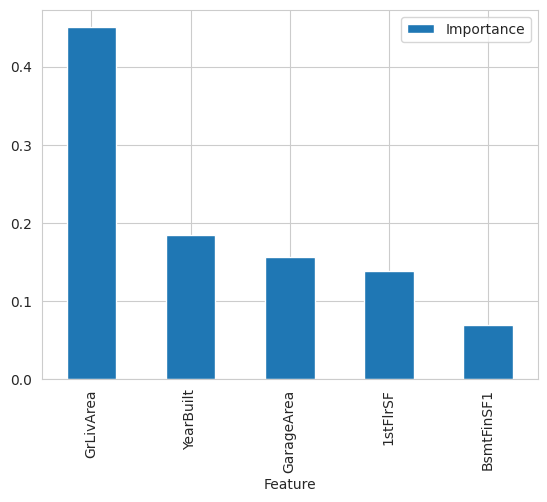

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate performance

Model Evaluation 

* Train Set
R2 Score: 0.873
Mean Absolute Error: 18292.048
Mean Squared Error: 781627460.533
Root Mean Squared Error: 27957.601


* Test Set
R2 Score: 0.771
Mean Absolute Error: 23025.617
Mean Squared Error: 1582120679.697
Root Mean Squared Error: 39775.881




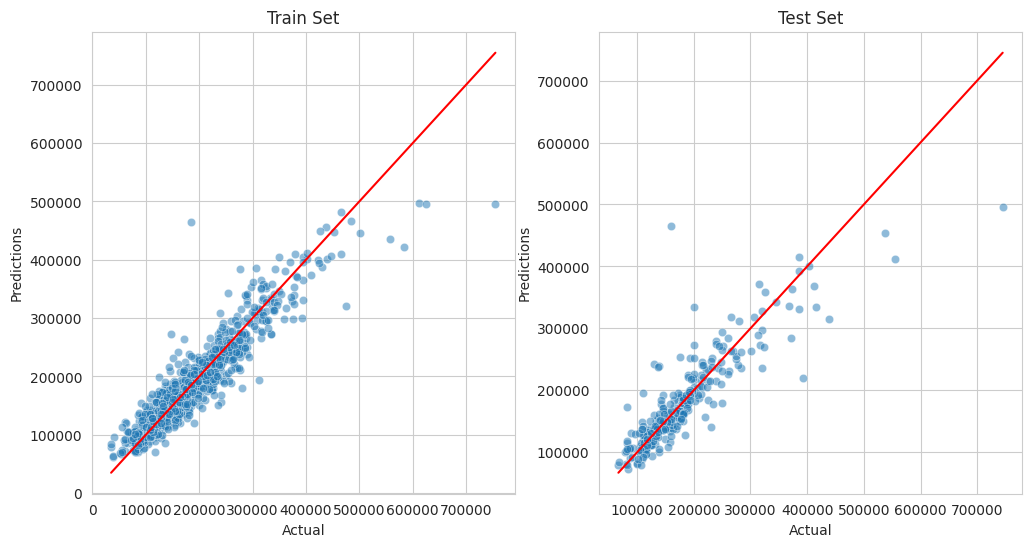

In [19]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## Summary


* In this notebook, the data cleaning and feature engineering steps were performed on the data.
* A quick grid search was used to narrow down the algorithms that predict the target best. 
* Hyperparameter optimisation was perfomed on the top three algorithms, which allowed the best model and combination of hyperparameters to be selected.
* The top three algorithms all generalised well on the test, with R2 scores > 0.75 (limit agreed with client). 
* The table below summarises the results for the top three algorithms after hyperparameter optimisation:

|Search	|estimator|	r2_train|	r2_test|	r2_train - r2_test|	Outcome|
|:----|:----|:----|:----|:----|:----|
|2	|RandomForestRegressor|	0.970|	0.794	|0.176|	Model generalises reasonably well on unseen data. Possible overfitting.|
|3	|ExtraTreesRegressor|	0.999	|0.848|	0.151|	Best generalisation on test set. Extremely high R2 score on train set indicates overfitting. |
|4	|GradientBoostingRegressor	|0.873	|0.771|	0.102|	Model generalises reasonably well on unseen data. Least overfitting of models tested. Best balance between generalisation performance and potential overfitting.|

* Based on this data it was decided that GradientBoostingRegressor was the best model to use for sale price prediction.
* Since the model generalizes well on unseen data and achieves R2 scores greater than 0.75, we are satisfied with its performance and do not deem it necessary to explore other methods such as PCA (Principal Component Analysis) regression. Additionally, given the satisfactory results, there is no need to iterate on data cleaning and feature engineering stages.

## Best ML Pipeline for Modelling

In [20]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

        ("CategoricalImputation", CategoricalImputer(imputation_method='missing',fill_value='Unf', 
                                                        variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', 
                                                variables=['LotFrontage', '2ndFlrSF', 'MasVnrArea'])),

        ("MeanImputation", MeanMedianImputer(imputation_method='mean', variables='BedroomAbvGr')),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['LotArea', 'LotFrontage'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['BsmtUnfSF', 'OpenPorchSF'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables='TotalBsmtSF')),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, 
                                                                selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [21]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{'model__n_estimators': [140],
                                  'model__max_depth': [3],
                                  'model__min_samples_leaf': [50],
                                  'model__max_leaf_nodes': [50],
                            }
}


In [22]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/feature_engine/select

In [23]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__n_estimators
0,GradientBoostingRegressor,0.729089,0.80314,0.858044,0.047421,3,50,50,140


In [24]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [25]:
# Defining the best pipeline

pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('CategoricalImputation',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['LotFrontage', '2ndFlrSF',
                                              'MasVnrArea'])),
                ('MeanImputation',
                 MeanMedianImputer(imputation...
                                                     'GrLivArea', 'KitchenQual',
                                                     'LotArea', 'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                             

Model Evaluation 

* Train Set
R2 Score: 0.873
Mean Absolute Error: 18292.048
Mean Squared Error: 781627460.533
Root Mean Squared Error: 27957.601


* Test Set
R2 Score: 0.771
Mean Absolute Error: 23025.617
Mean Squared Error: 1582120679.697
Root Mean Squared Error: 39775.881




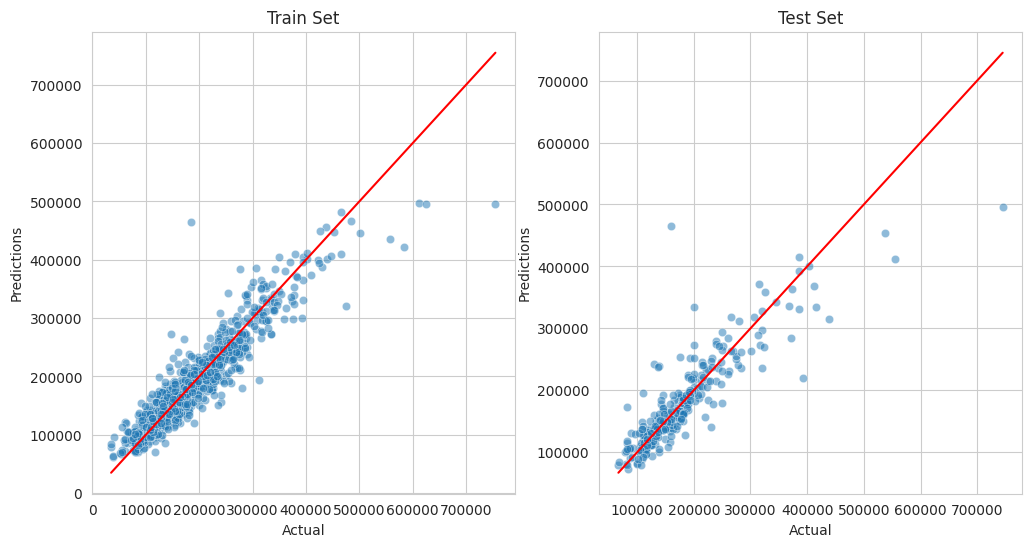

In [26]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regression)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)

---

# Push Files to Repo

Generate the following files:
* Train Set
* Test Set
* Modelling Pipeline
* Feature importance Plot

In [27]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)
    


## Train Set: Features and Target

In [28]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,11694,90.0,452.0,108,5,9,1822,NaN,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,6600,60.0,0.0,0,5,5,894,NaN,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,13360,80.0,0.0,0,7,5,876,NaN,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,NaN,857,RFn,...,13265,NaN,148.0,59,5,8,1568,NaN,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,NaN,843,RFn,...,13704,118.0,150.0,81,5,7,1541,NaN,2001,2002


In [29]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [30]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [31]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features and Target

In [32]:
X_test.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
529,2515,0.0,4.0,No,1219,Rec,816,NaN,484,NaN,...,32668,NaN,NaN,0,3,6,2035,NaN,1957,1975
491,958,620.0,3.0,No,403,BLQ,238,NaN,240,Unf,...,9490,79.0,0.0,0,7,6,806,NaN,1941,1950
459,979,224.0,3.0,No,185,LwQ,524,NaN,352,Unf,...,7015,NaN,161.0,0,4,5,709,NaN,1950,1950
279,1156,866.0,4.0,No,392,BLQ,768,0.0,505,Fin,...,10005,83.0,299.0,117,5,7,1160,288.0,1977,1977
655,525,NaN,3.0,No,0,Unf,525,NaN,264,Unf,...,1680,21.0,381.0,0,5,6,525,NaN,1971,1971


In [33]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [34]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [35]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling Pipeline

In [36]:
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('CategoricalImputation',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['LotFrontage', '2ndFlrSF',
                                              'MasVnrArea'])),
                ('MeanImputation',
                 MeanMedianImputer(imputation...
                                                     'GrLivArea', 'KitchenQual',
                                                     'LotArea', 'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                             

In [37]:

joblib.dump(value=pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/regression_pipeline.pkl']

## Feature Importance Plot

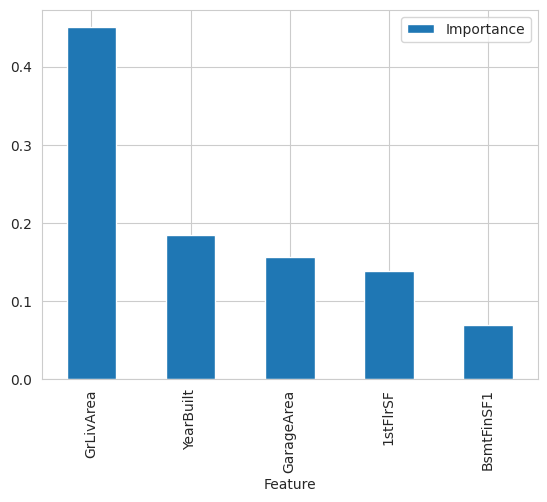

In [38]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

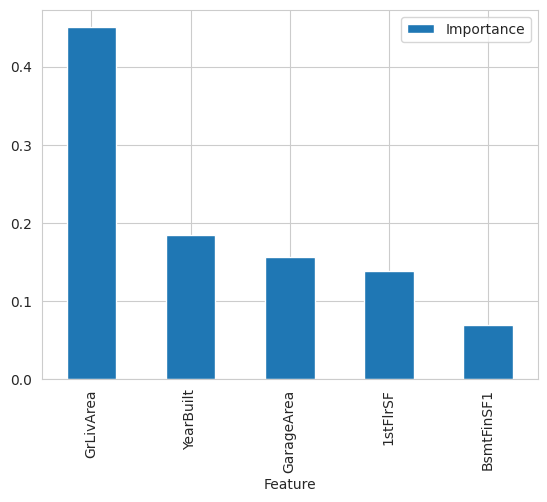

In [39]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

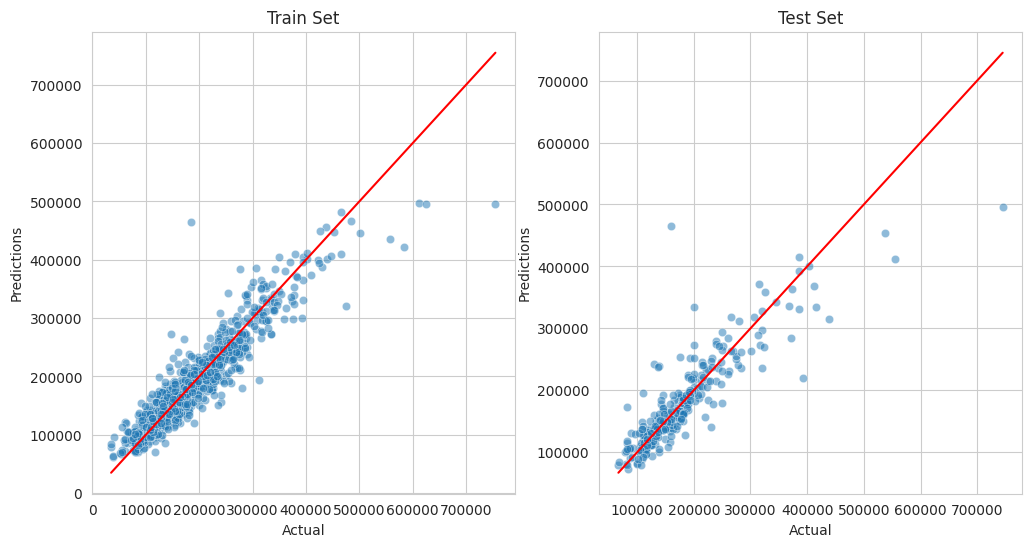

In [40]:
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    # plt.show()
    plt.savefig(f'{file_path}/model_performance_evaluation.png', bbox_inches='tight')

regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)